<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final project - Introduction to DS
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

## Problem statement

Sử dụng dữ liệu thu thập được để tạo một hệ thống đề xuất video youtube cho người dùng thông qua một đoạn văn "promt" mà người dùng nhập vào

## Import

In [1]:
import pandas as pd
import numpy as np
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer

# Sklearn model and util functions
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn import metrics


SEED = 2023

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data preparation

Read clean data

In [2]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [3]:
# clean_df.sample(5)

Clean the video title

In [4]:
# clean_df['title'].sample(5)

In [5]:
# Preprocess the data: convert to lowercase, remove special characters, and stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [token for token in text.split() if token not in stop_words]
    return ' '.join(tokens)

clean_df['clean_title'] = clean_df['title'].apply(preprocess_text)
clean_df['clean_title'] = clean_df['clean_title'] + "|" + clean_df['video_id']


In [6]:
# clean_df['clean_title'].sample(5)

Create a TF-IDF vectorizer

In [7]:
# Create a TF-IDF vectorizer to vectorize the text
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(clean_df['clean_title'])

TfidfVectorizer(stop_words='english')

Split data into training, validating and testing set

In [8]:
# Split the data into `train` and `vaild + test` sets
train_data, temp_data = train_test_split(clean_df['clean_title'], 
                                         test_size=0.2, random_state=SEED)
# Further split the temporary set into validation and test sets
valid_data, test_data = train_test_split(temp_data,
                                         test_size=0.5, random_state=SEED)


## Baseline Model Comparison


------------------ Fold 1 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 2 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 3 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 4 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 5 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...


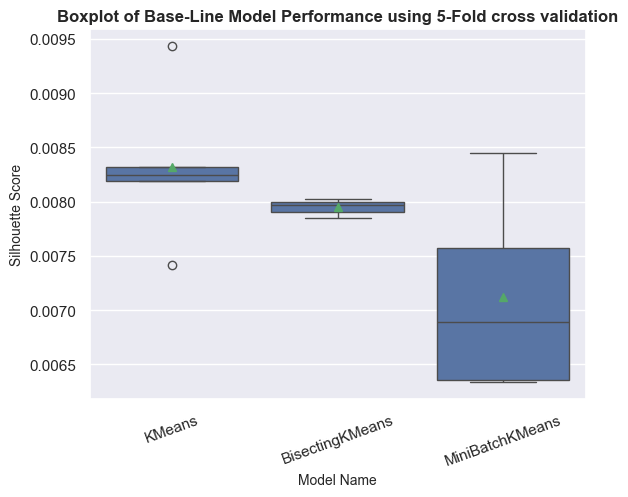

In [9]:
# Define a dictionary to store clustering models
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
parameters = {
    "n_clusters": 12, "init": "k-means++", "n_init": 10, 
    "max_iter": 400, "tol": 1e-8, "verbose": 0, 
    "random_state": SEED
}
clustering_models = {
    'KMeans': KMeans(**parameters),
    'BisectingKMeans': BisectingKMeans(**parameters),
    'MiniBatchKMeans': MiniBatchKMeans(**parameters),
}

# Define K-Fold cross-validation
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Store the history of cross-validation process
entries = []

# Do k-fold cross validation
for i, (train_ids, val_ids) in enumerate(kfold.split(train_data), start=1):
    # Check for duplicates index in `train_ids` and `val_ids`
    assert len(set(train_ids).intersection(set(val_ids))) == 0

    # Convert text to numerical data using TF-IDF
    data_to_train = vectorizer.transform(train_data.iloc[train_ids])
    data_to_valid = vectorizer.transform(train_data.iloc[val_ids])

    print(f"\n------------------ Fold {i} ------------------")
    for model_name, model in clustering_models.items():
        print(f"{model_name.rjust(15)}: Fitting... ", end="")
        
        # Fit the model to the training data
        model.fit(data_to_train)

        # Evaluate the model on the validation data
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
        print(f"-> Evaluating...")
        labels_pred = model.predict(data_to_valid)
        silhouette_score \
            = metrics.silhouette_score(data_to_valid, 
                                       labels_pred, metric='euclidean')

        # Add new record to the history
        entries.append([model_name, i, silhouette_score])

# Create a dataframe to store the results
cross_validation_df = pd.DataFrame(
    data=entries,
    columns=["model_name", "fold_id", "silhouette_score"]
)

# Plot the results
sns.boxplot(x='model_name', y='silhouette_score', 
            data=cross_validation_df, showmeans=True)
plt.title(f"Boxplot of Base-Line Model Performance using {K_FOLDS}-Fold cross validation",
          fontsize=12, fontweight="bold")
plt.xlabel("Model Name", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.xticks(rotation=20)
plt.show();
# ~ 3min

Summarize the results

In [10]:
# Summarize the results
baseline_results = \
    cross_validation_df.groupby('model_name')["silhouette_score"]\
        .agg(['mean', 'std']).sort_values(by='mean', ascending=False)

# Add metric names
baseline_results.columns.name = "silhouette_score"

baseline_results

silhouette_score,mean,std
model_name,,
KMeans,0.008319,0.000719
BisectingKMeans,0.007949,0.000074
MiniBatchKMeans,0.007120,0.000899


> Nhận xét: `KMeans` là "baseline model" chạy tốt nhất trên tập dữ liệu `train_data`. Ở bước tiếp theo, ta cần thực hiện "Hyper-parameter Tuning" để giúp model tạo ra kết quả tốt hơn nữa.

## Hyper-parameter Tuning

In [11]:
# TODO:
train

NameError: name 'train' is not defined

## Clustering video title

In [ ]:
def my_clustering(s, n_clusters, print_clusters=False): 
    text_values = s

    # Convert text to numerical data using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_values)

    # Choose the number of clusters (you may need to adjust this based on your data)
    num_clusters = n_clusters

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)

    # Print the clusters
    if print_clusters:
        # Get cluster labels
        cluster_labels = kmeans.labels_
        for i in range(num_clusters):
            print(f"Cluster {i + 1}:")
            cluster_texts = np.array(text_values)[cluster_labels == i]
            for text in cluster_texts:
                print(f"  - {text}")
            print("\n")
    
    return kmeans, vectorizer

In [ ]:
# N_CLUSTERS = 5
# kmeans_model, *vectorizer = my_clustering(clean_df['clean_title'], n_clusters=N_CLUSTERS, print_clusters=True)
# vectorizer = vectorizer[0]

In [ ]:
# # Assuming 'new_data' is a list of new video titles
# new_data = ["Introduction to Natural Language Processing",
#             "Advanced Python Programming",
#             "Latest Technology Trends in 2024",
#             "How to learn data science in 2023",
#             "Top 10 Python tips and tricks",
#             "Machine learning explained in 5 minutes",
#             "Cooking hacks for beginners",
#             "Latest tech news and updates"]

# new_data = pd.Series(new_data)
# new_data = new_data.apply(preprocess_text)
# text_values = new_data

# # Transform the preprocessed new data into TF-IDF features using the same vectorizer
# new_tfidf_matrix = vectorizer.transform(text_values)

# # Use the trained k-means model to predict cluster labels for the new data
# new_cluster_labels = kmeans_model.predict(new_tfidf_matrix)

# # Display the results
# for i, title in enumerate(new_data):
#     print(f"Cluster {new_cluster_labels[i]} | Title: {title}")

## Clustering tags

# -------------------- BREAK --------------------

## Feature engineering

In [ ]:
target = "viewCount"
X = clean_df.copy()
X.drop(target, axis=1, inplace=True)
y = clean_df[target].copy()

cat_cols = [col for col in X.columns if X[col].dtype == "object"]
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    # X_val[col] = le.transform(X_val[col])
    # X_test[col] = le.transform(X_test[col])

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

## Training model

In [ ]:
# YOUR CODE HERE (OPTION) 

## Evaluation

In [ ]:
# YOUR CODE HERE (OPTION) 

## Prediction

In [ ]:
# YOUR CODE HERE (OPTION) 

## Results analysis

In [ ]:
# YOUR CODE HERE (OPTION) 

## Conclusion

**Your conclusion**